### Build Equiangular weight matrix

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import sys
import hashlib
import zipfile

import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import healpy as hp

plt.rcParams['figure.figsize'] = [10, 10]

In [3]:
import numpy as np
from scipy import sparse

from pygsp import utils
from pygsp.graphs import Graph
from pygsp.graphs import NNGraph

In [1157]:
class SphereIcosahedron(NNGraph):
    def __init__(self, order, sampling='vertex', **kwargs):
        from collections import deque
        ## sampling in ['vertex', 'face']
        self.intp = None
        PHI = (1 + np.sqrt(5))/2
        radius = np.sqrt(PHI**2+1)
        coords = np.zeros((12,3))
        pointUpFor = deque([0, 1, PHI])
        pointUpBack = deque([0, -1, PHI])
        pointDownFor = deque([0, 1, -PHI])
        pointDownBack = deque([0, -1, -PHI])
        for i in range(3):
            coords[4*i] = pointUpFor
            coords[4*i+1] = pointUpBack
            coords[4*i+2] = pointDownFor
            coords[4*i+3] = pointDownBack
            pointUpFor.rotate()
            pointUpBack.rotate()
            pointDownFor.rotate()
            pointDownBack.rotate()
        coords = coords/radius
        faces = [1, 2, 7, 1, 7, 10, 1, 10, 9, 1, 9, 5, 1, 5, 2, 2, 7, 12, 12, 7, 8, 7, 8, 10, 8, 10, 3, 10, 3, 9, 3, 9, 6, 9, 6, 5, 6, 5, 11, 5, 11, 2, 11, 2, 12, 4, 11, 12, 4, 12, 8, 4, 8, 3, 4, 3, 6, 4, 6, 11]
        self.faces = np.reshape(faces, (20,3))-1
        self.order = order
        self.coords = coords
        ## rotate icosahedron?
        for i in range(order):
            self.divide()
        
        if sampling=='faces':
            self.coords = self.coords[self.faces].mean(axis=1)
#         theta = [0] + 5*[np.pi/2-np.arctan(0.5)] + 5*[np.pi/2+np.arctan(0.5)] + [np.pi]
#         phi = [0] + np.linspace(0, 2*np.pi, 5, endpoint=False).tolist() +  (np.linspace(0, 2*np.pi, 5, endpoint=False)+(np.pi/5)).tolist() + [0]
        
        self.npix = len(self.coords)
        #W = np.ones((self.npix, self.npix))
        
        neighbours = 3 if 'face' in sampling else (5 if order == 0 else 6)
        super(SphereIcosahedron, self).__init__(self.coords, k=neighbours, **kwargs)
        
    def divide(self):
        face_index = np.arange(len(self.faces))
        faces = self.faces[face_index]
        triangles = self.coords[faces]
        src_idx = np.vstack([faces[:, g] for g in [[0, 1], [1, 2], [2, 0]]])
        mid = np.vstack([triangles[:, g, :].mean(axis=1) for g in [[0, 1], [1, 2], [2, 0]]])
        mid_idx = (np.arange(len(face_index) * 3)).reshape((3, -1)).T
#         _, unique, inverse = np.unique(mid, return_index=True, return_inverse=True)#unique_rows(mid)
#         mid = mid[unique]
#         src_idx = src_idx[unique]
#         mid_idx = inverse[mid_idx] + len(self.coords)
        f = np.column_stack([faces[:, 0], mid_idx[:, 0], mid_idx[:, 2],
                             mid_idx[:, 0], faces[:, 1], mid_idx[:, 1],
                             mid_idx[:, 2], mid_idx[:, 1], faces[:, 2],
                             mid_idx[:, 0], mid_idx[:, 1], mid_idx[:, 2], ]).reshape((-1, 3))
        # add the 3 new faces per old face
        new_faces = np.vstack((faces, f[len(face_index):]))
        # replace the old face with a smaller face
        new_faces[face_index] = f[:len(face_index)]
        new_vertices = np.vstack((self.coords, mid))
        nv = self.coords.shape[0]
        identity_map = np.stack((np.arange(nv), np.arange(nv)), axis=1)
        src_id = np.concatenate((identity_map, src_idx), axis=0)
        self.coords = new_vertices
        self.faces = new_faces
        self.intp = src_id

2019-05-06 15:54:58,228:[WARNING](pygsp.graphs.graph.check_weights): The main diagonal of the weight matrix is not 0!


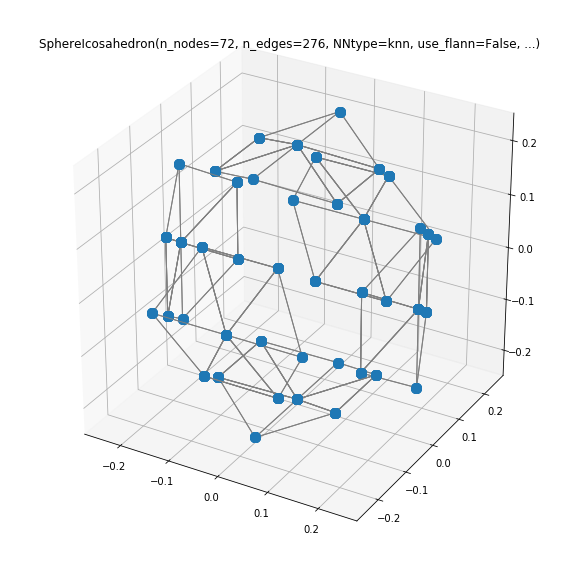

In [1158]:
gIcosa = SphereIcosahedron(1, sampling='vertex')
gIcosa.plot()

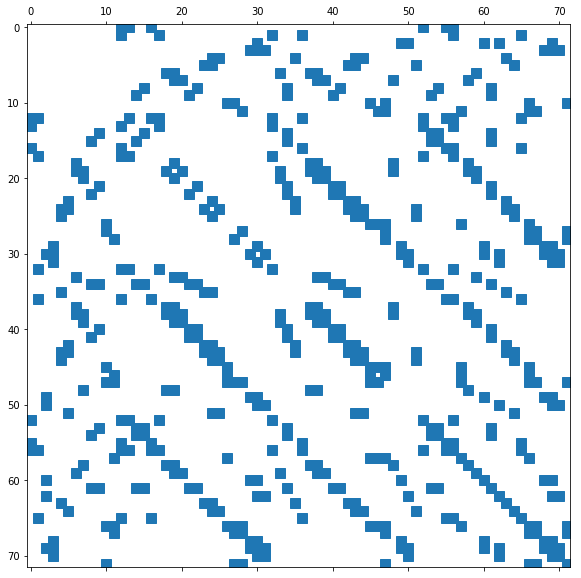

In [1159]:
plt.spy(gIcosa.W)

In [356]:
class SphereHealpixNN(NNGraph):
    def __init__(self, nside, n_neighbors, nest=True, **kwargs):
        import healpy as hp
        self.nside = nside
        npix = 12 * nside**2
        indexes = np.arange(npix)
        x, y, z = hp.pix2vec(nside, indexes, nest=nest)
        coords = np.vstack([x, y, z]).transpose()
        coords = np.asarray(coords, dtype=np.float32)
        
        plotting = {
            'vertex_size': 80,
            "limits": np.array([-1, 1, -1, 1, -1, 1])
        }
        
        super(SphereHealpixNN, self).__init__(coords, k=n_neighbors, center=False, rescale=False,
                                     plotting=plotting, **kwargs)
        

In [354]:
class SphereHealpix(Graph):
    def __init__(self, nside, nest=True, **kwargs):
        import healpy as hp
        self.nside = nside
        npix = 12 * nside**2
        indexes = np.arange(npix)
        x, y, z = hp.pix2vec(nside, indexes, nest=nest)
        coords = np.vstack([x, y, z]).transpose()
        coords = np.asarray(coords, dtype=np.float32)
        
        neighbors = hp.pixelfunc.get_all_neighbours(nside, indexes, nest=nest)
        col_index = neighbors.T.reshape((npix * 8))
        row_index = np.repeat(indexes, 8)
        keep = (col_index < npix)
        # Remove fake neighbors (some pixels have less than 8).
        keep &= (col_index >= 0)
        col_index = col_index[keep]
        row_index = row_index[keep]
        distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
        plt.hist(distances, 100)
        kernel_width = np.mean(distances)
        weights = np.exp(-distances / (2 * kernel_width))
        W = sparse.csr_matrix(
            (weights, (row_index, col_index)), shape=(npix, npix), dtype=np.float32)
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(SphereHealpix, self).__init__(W=W, coords=coords,
                                     plotting=plotting, **kwargs)
        

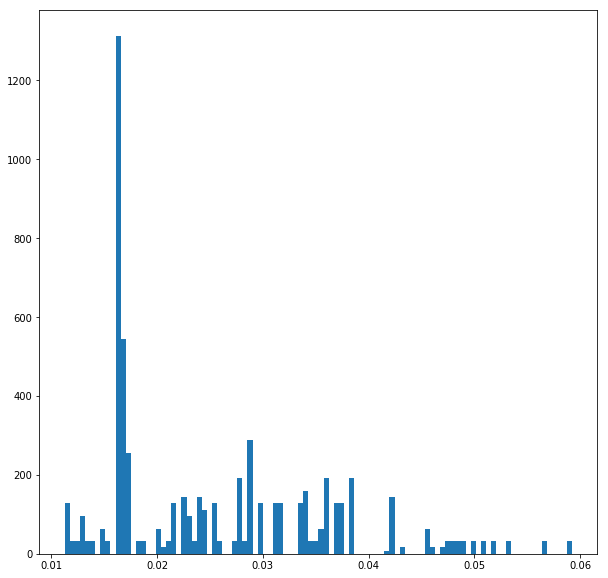

In [366]:
graphHp = SphereHealpix(8, True)
graphHpNN = SphereHealpixNN(8, 6, True)

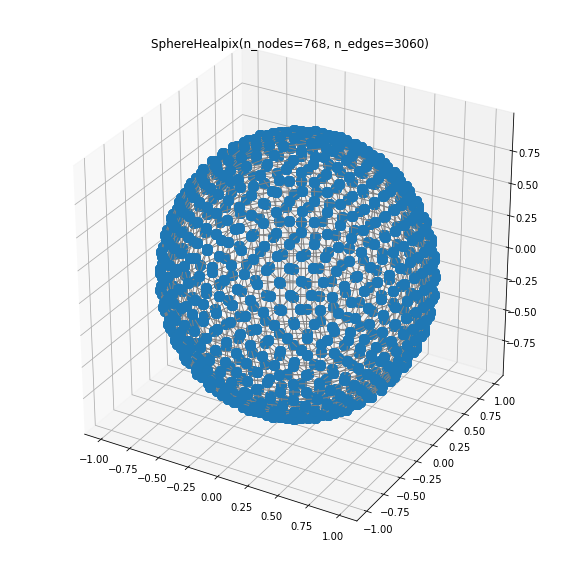

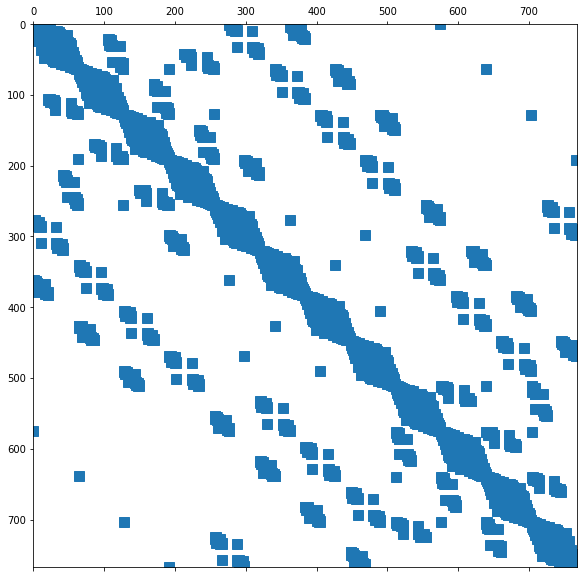

In [367]:
graphHp.plot()
plt.figure()
plt.spy(graphHp.W)

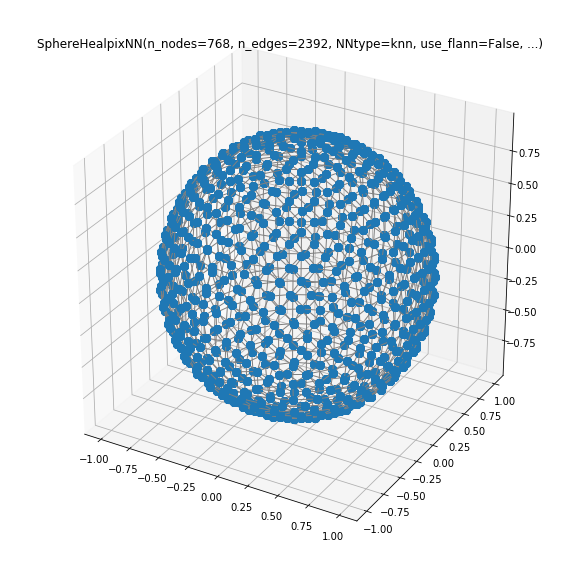

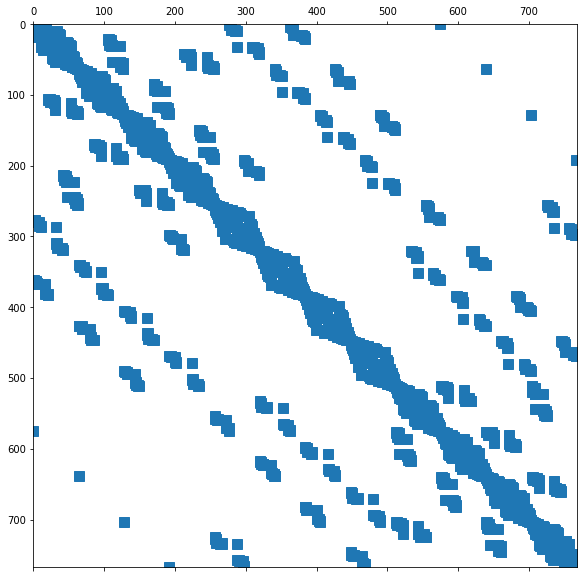

In [368]:
graphHpNN.plot()
plt.figure()
plt.spy(graphHpNN.W)

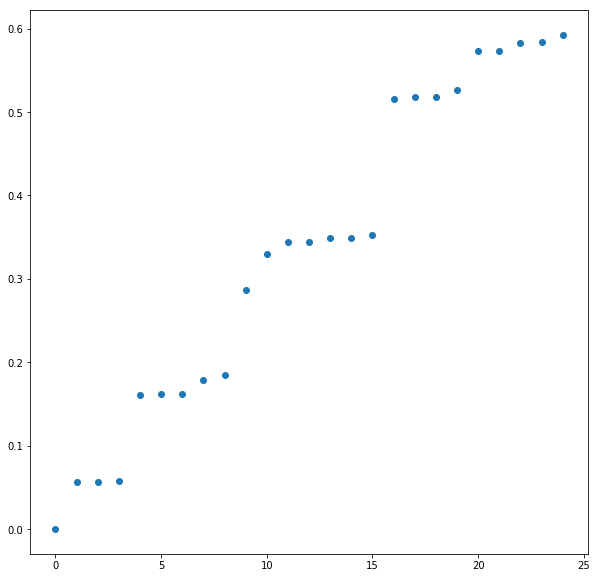

In [370]:
plt.plot(graphHp.e[:25], 'o')

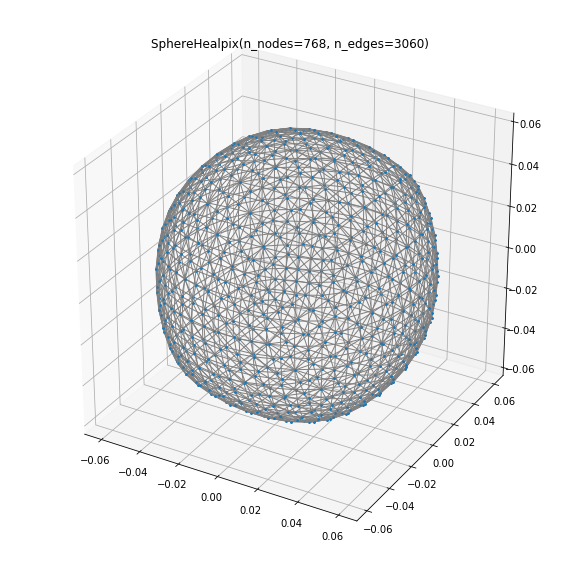

In [1160]:
graphHp.compute_laplacian("combinatorial")
#graphCyl.compute_fourier_basis(recompute=True)
graphHp.set_coordinates(graphHp.U[:,1:4])
graphHp.plot(vertex_size=10)

In [254]:
class SphereEquiangular(Graph):
    def __init__(self, bw=64, sptype='DH', pole='all', neighbors=8, weights=None, dist='geodesic', 
                 affine=0., **kwargs):
        """Sphere with an equiangular sampling
         Parameters
        ----------
        bw : int
            bandwidth, size of grid  (default = 64)
        sptype: str
            sampling type, possible arguments are 'DH', 'SOFT', ... (default = 'DH')
        pole: str
            how to manage the pole of the sphere, possible arguments are 'all', 'one', 'zero' (default = 'all')
        ---------
        TODO: unique on neighbor
        TODO: CC and GL are not equiangular and must be implement in other ways
        """
        self.bw = bw
        self.sptype = sptype
        self.pole = pole
        if pole not in ['all', 'one', 'zero']:
            raise ValueError('Unknown pole value:' + pole) 
        if sptype not in ['DH', 'SOFT']:
            raise ValueError('Unknown sampling type:' + sptype) 
        if sptype is not 'DH' and pole is not 'zero':
            print('pole can be only zero with sampling type ' + sptype)
            pole = 'zero'
        
        ## sampling and coordinates calculation
        if sptype is 'DH':
            beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
            alpha = np.arange(2 * bw) * np.pi / bw
            if pole is 'zero':
                beta = np.arange(2 * bw + 1) * np.pi / (2. * bw + 1)
        elif sptype is 'SOFT':  # SO(3) Fourier Transform optimal
            beta = np.pi * (2 * np.arange(2 * bw) + 1) / (4. * bw)
            alpha = np.arange(2 * bw) * np.pi / bw
        elif sptype == 'CC':  # Clenshaw-Curtis
            beta = np.linspace(0, np.pi, 2 * bw + 1)
            alpha = np.linspace(0, 2 * np.pi, 2 * bw + 2, endpoint=False)
        elif sptype == 'GL':  # Gauss-legendre
            from numpy.polynomial.legendre import leggauss
            x, _ = leggauss(bw + 1)  # TODO: leggauss docs state that this may not be only stable for orders > 100
            beta = np.arccos(x)
            alpha = np.arange(2 * bw + 2) * np.pi / (bw + 1)
        if pole is not 'all' and sptype is 'DH':
            beta = beta[1:]
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        if pole is 'one':
            coords = np.vstack([[0., 0., 1.],coords])
        coords = np.asarray(coords, dtype=np.float32)
        
        ## neighbors and weight matrix calculation
        def south(x, bw):
            if x >= (2*bw)*(2*bw-1):
                return north((x+bw)%(2*bw)+(2*bw)*(2*bw),bw)
            elif self.pole is 'zero' and x >= (2*bw)*(2*bw-1):
                return north((x+bw)%(2*bw)+(2*bw)*(2*bw-1),bw)
            else:
                return x + 2*bw

        def north(x, bw):
            if x < 2*bw:
                return (x+bw)%(2*bw)
            else:
                return x - 2*bw

        def west(x, bw):
            if x%(2*bw)==0:
                x += 2*bw
            return x -1

        def east(x, bw):
            if x%(2*bw)==2*bw-1:
                x -= 2*bw
            return x + 1

        npix = len(coords)
        col_index=[]
        for ind in range(len(coords)):
            # first line is the same point, so is connected to all points of second line
            if pole is 'all' and sptype and ind < 2* bw:
                if ind == 0:
                    neighbor = np.arange(2*bw)+2*bw # np.arange(1,4*bw)
                else:
                    neighbor = np.arange(2*bw)+2*bw # [0]
            elif pole is 'all' and ind < 4*bw:
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
                neighbor += list(range(2*bw)) # [0]
            elif pole is 'one' and ind == 0:
                neighbor = np.arange(1, 2*bw+1)
            elif pole is 'one' and ind < 2*bw+1:
                ind += 2*bw - 1
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
                neighbor += [0]
            else:
                if pole is 'one':
                    ind += 2*bw - 1
                if neighbors==8:
                    neighbor = [south(west(ind,bw),bw), west(ind,bw), north(west(ind,bw), bw), north(ind,bw), 
                                north(east(ind,bw),bw), east(ind,bw), south(east(ind,bw),bw), south(ind,bw)]
                elif neighbors==4:
                    neighbor = [west(ind,bw), north(ind,bw), east(ind,bw), south(ind,bw)]
                else:
                    neighbor = []
            neighbor = np.asarray(neighbor)
            if pole is 'one' and ind != 0:
                neighbor -= 2*bw - 1
                neighbor[neighbor<0] = 0
            #neighbors.append(neighbor)
            col_index += list(neighbor)
        # neighbors = np.asarray(neighbors)
        col_index = np.asarray(col_index)

        #col_index = neighbors.reshape((-1))
        if pole is 'all':
            row_index = np.hstack([np.repeat(np.arange(0,2*bw), 2*bw), np.repeat(np.arange(2*bw,4*bw), neighbors//2+1+2*bw),#2*bw+5), 
                                  np.repeat(np.arange(4*bw, npix), neighbors)])
        elif pole is 'one':
            row_index = np.hstack([np.repeat(0, 2*bw), np.repeat(np.arange(1, 2*bw+1), neighbors//2+2),
                                  np.repeat(np.arange(2*bw+1, npix), neighbors)])
        elif pole is 'zero':
            row_index = np.repeat(np.arange(npix), neighbors)

        distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)
        # slower: np.linalg.norm(coords[row_index] - coords[col_index], axis=1)**2
        if dist=='geodesic':
            distances = np.zeros(len(row_index))
            for i, (pos1, pos2) in enumerate(zip(coords[row_index], coords[col_index])):
                d1, d2 = hp.rotator.vec2dir(pos1.T, lonlat=False).T, hp.rotator.vec2dir(pos2.T, lonlat=False).T
                distances[i] = hp.rotator.angdist(d1, d2, lonlat=False)

        # Compute similarities / edge weights.
        kernel_width = np.mean(distances)
        kernel_width2 = np.median(distances)
#         distances = kernel_width*(distances/kernel_width) ** 0.1
        slope = (kernel_width*(0.95-affine))/(kernel_width*0.95)
        distances[distances<(kernel_width*0.95)] = affine*kernel_width + distances[distances<(kernel_width*0.95)] * slope
#         distances[distances<(kernel_width*0.8)] = kernel_width*0.8
#         distances[distances>(kernel_width)] = kernel_width
#         distances[distances<(kernel_width)] = kernel_width*(distances[distances<(kernel_width)]/kernel_width) ** 0.05#kernel_width*0.8
#         distances[distances>(kernel_width)] = kernel_width*(distances[distances>(kernel_width)]/kernel_width) ** 0.5#distances[distances>(kernel_width*1.3)]/2
        if isinstance(weights, int):
            kernel_width = weights
        weights = np.exp(-distances / (2 * kernel_width))
        
        plt.hist(distances, 100)
        
        if weights == 'one':
            weights = distances/distances


        # Similarity proposed by Renata & Pascal, ICCV 2017.
        # weights = 1 / distances

        # Build the sparse matrix.
        W = sparse.csr_matrix(
            (weights, (row_index, col_index)), shape=(npix, npix), dtype=np.float32)
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(SphereEquiangular, self).__init__(W=W, coords=coords,
                                     plotting=plotting, **kwargs)

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel_launcher.py:166: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


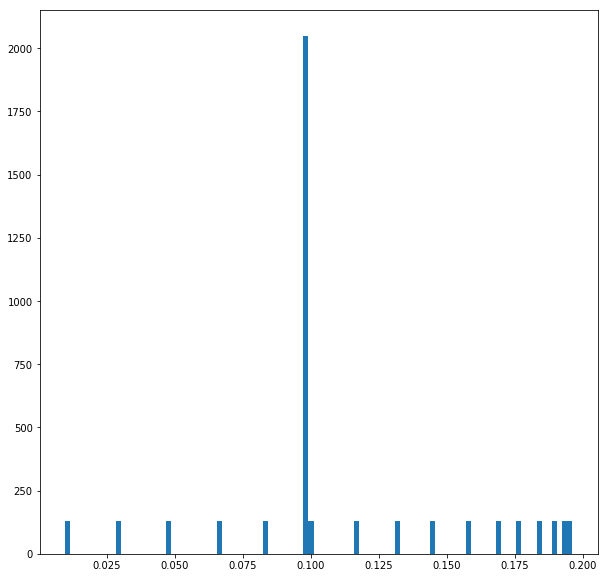

In [581]:
graphAll = SphereEquiangular(16, 'SOFT', 'zero', 4)

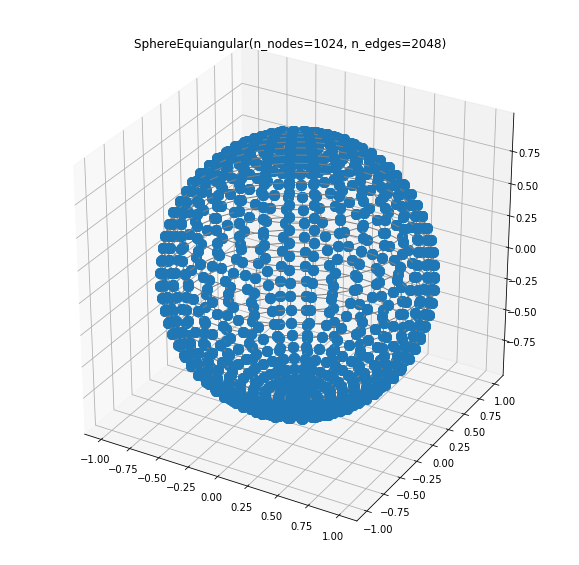

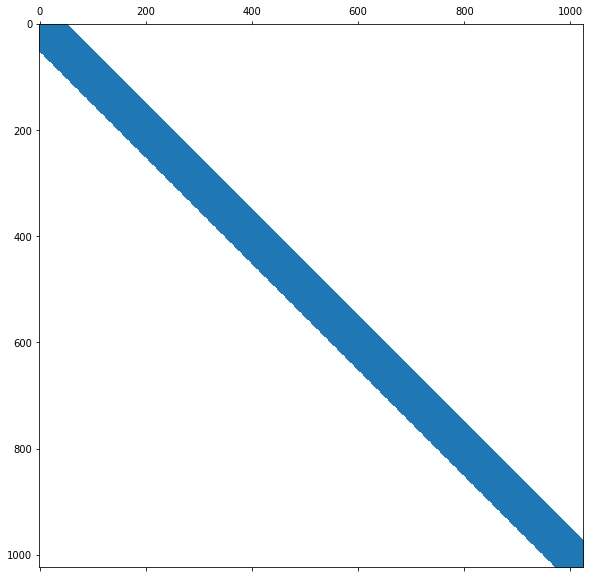

In [488]:
graphAll.plot()
plt.figure()
plt.spy(graphAll.W)

In [45]:
graphAll = SphereEquiangular(2, 'DH', 'all')

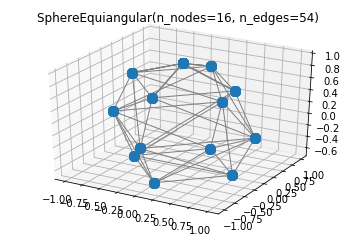

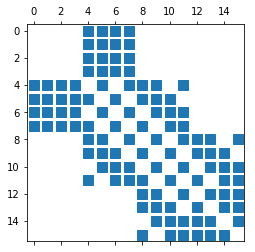

In [46]:
graphAll.plot()
plt.figure()
plt.spy(graphAll.W)

In [47]:
graphOne = SphereEquiangular(2, 'DH', 'one')

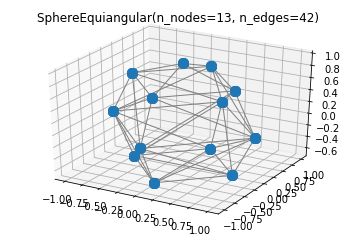

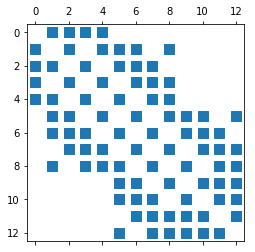

In [48]:
graphOne.plot()
plt.figure()
plt.spy(graphOne.W)

In [49]:
graphZero = SphereEquiangular(2, 'DH', 'zero')

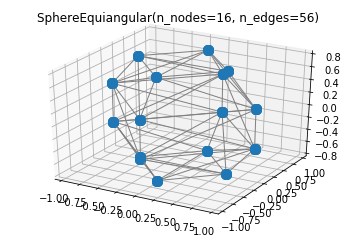

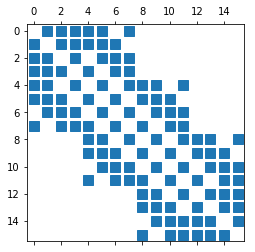

In [50]:
graphZero.plot()
plt.figure()
plt.spy(graphZero.W)

/home/gusset/miniconda3/envs/PDMsphere/lib/python3.6/site-packages/ipykernel_launcher.py:166: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


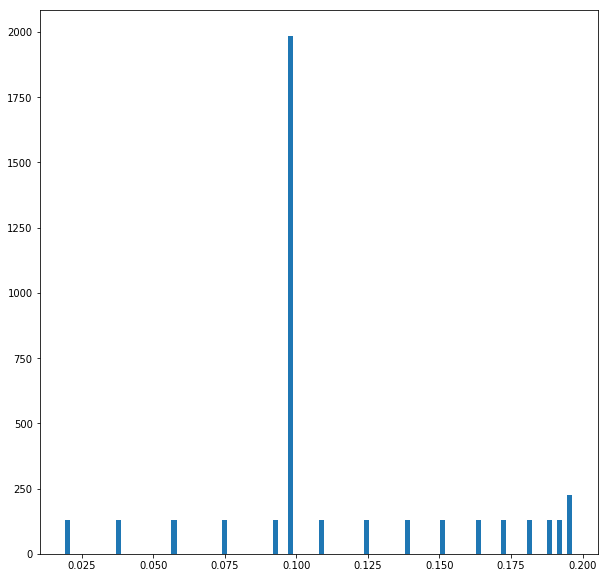

In [259]:
graphEqui = SphereEquiangular(16, 'DH', 'one', 4, dist='geodesic', affine=0.)

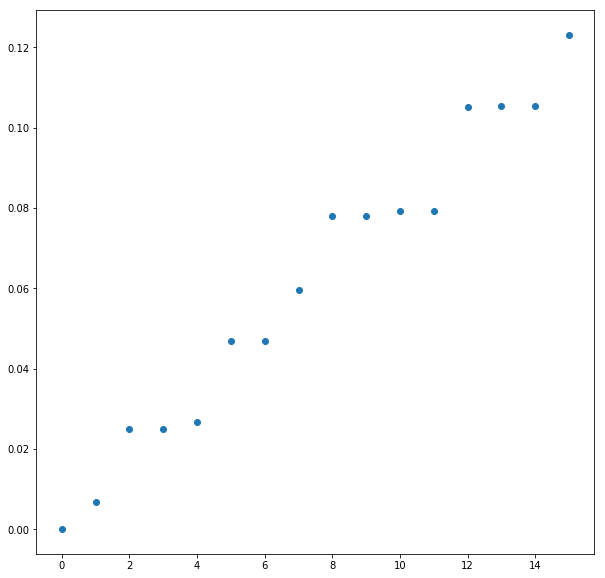

In [261]:
plt.plot(graphEqui.e[:16], 'o')

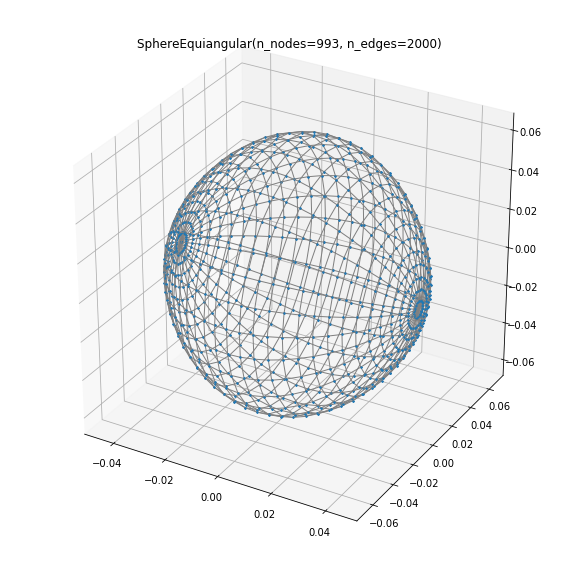

<Figure size 720x720 with 0 Axes>

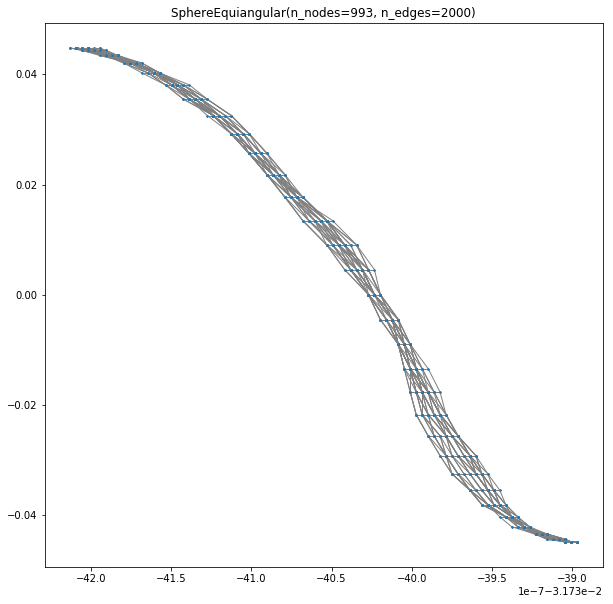

In [262]:
graphEqui.compute_laplacian("combinatorial")
#graphAll.compute_fourier_basis(recompute=True)
graphEqui.set_coordinates(graphEqui.U[:,1:4])
graphEqui.plot(vertex_size=10)

In [776]:
class SphereEquiangularNN(NNGraph):
    def __init__(self, bw=64, sptype='DH', pole='zero', neighbors=8, weights=None,  **kwargs):
        """Sphere with an equiangular sampling
         Parameters
        ----------
        bw : int
            bandwidth, size of grid  (default = 64)
        sptype: str
            sampling type, possible arguments are 'DH', 'SOFT', ... (default = 'DH')
        pole: str
            how to manage the pole of the cylinder, possible arguments are 'disconnected', 'connected' (default = 'disconnected')
        ---------
        TODO: unique on neighbor
        TODO: CC and GL are not equiangular and must be implement in other ways
        """
        self.bw = bw
        self.sptype = sptype
        self.pole = pole
        if pole not in ['all', 'zero', 'one']:
            raise ValueError('Unknown pole value:' + pole) 
        if sptype not in ['DH', 'SOFT', 'CC', 'GL', 'OD']:
            raise ValueError('Unknown sampling type:' + sptype) 
        if sptype is not 'DH' and pole is not 'zero':
            print('pole can be only zero with sampling type ' + sptype)
            pole = 'zero'
        
        ## sampling and coordinates calculation
        if sptype is 'DH':
            beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
            alpha = np.arange(2 * bw) * np.pi / bw
            if pole is 'zero':
                beta = np.arange(2 * bw + 1) * np.pi / (2. * bw + 1)
        elif sptype is 'SOFT':  # SO(3) Fourier Transform optimal
            beta = np.pi * (2 * np.arange(2 * bw) + 1) / (4. * bw)
            alpha = np.arange(2 * bw) * np.pi / bw
        elif sptype == 'CC':  # Clenshaw-Curtis
            beta = np.linspace(0, np.pi, 2 * bw + 1)
            alpha = np.linspace(0, 2 * np.pi, 2 * bw + 2, endpoint=False)
        elif sptype == 'GL':  # Gauss-legendre
            from numpy.polynomial.legendre import leggauss
            x, _ = leggauss(bw + 1)  # TODO: leggauss docs state that this may not be only stable for orders > 100
            beta = np.arccos(x)
            alpha = np.arange(2 * bw + 2) * np.pi / (bw + 1)
        if pole is not 'all' and sptype is 'DH':
            beta = beta[1:]
        if sptype == 'OD':  # Optimal Dimensionality
            theta, phi = np.zeros(4*bw**2), np.zeros(4*bw**2)
            index=0
            #beta = np.pi * (2 * np.arange(2 * bw) + 1) / (4. * bw)
            beta = np.pi * ((np.arange(2 * bw + 1)%2)*(4*bw-1)+np.arange(2 * bw + 1)*-1**(np.arange(2 * bw + 1)%2)) / (4 * bw - 1)
            for i in range(2*bw):
                alpha = 2 * np.pi * np.arange(2 * i + 1) / (2 * i + 1)
                end = len(alpha)
                theta[index:index+end], phi[index:index+end] = np.repeat(beta[i], end), alpha
                index += end
        else:
            theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        ct = np.cos(theta).flatten()
        st = np.sin(theta).flatten()
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        if pole is 'one':
            coords = np.vstack([[0., 0., 1.],coords])
        coords = np.asarray(coords, dtype=np.float32)
        self.npix = len(coords)
        if neighbors == 'all':
            neighbors = self.npix-1
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(SphereEquiangularNN, self).__init__(coords, k=neighbors, center=False, rescale=False,
                                     plotting=plotting, **kwargs)

In [777]:
equiNN = SphereEquiangularNN(4, 'OD', pole='zero', neighbors=6)

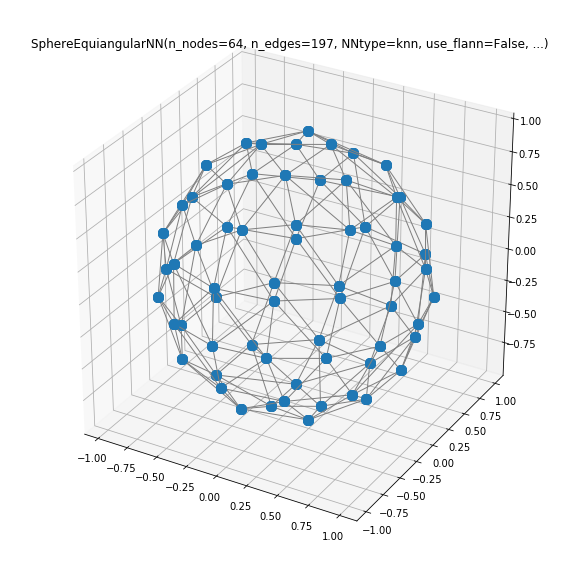

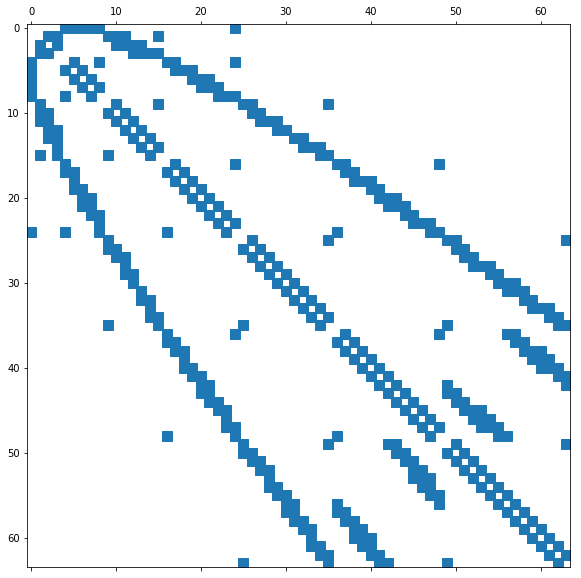

In [778]:
equiNN.plot()
plt.figure()
plt.spy(equiNN.W)

2019-05-03 11:10:34,433:[WARNING](pygsp.graphs.graph._check_fourier_properties): The eigenvalues vector G.e is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.


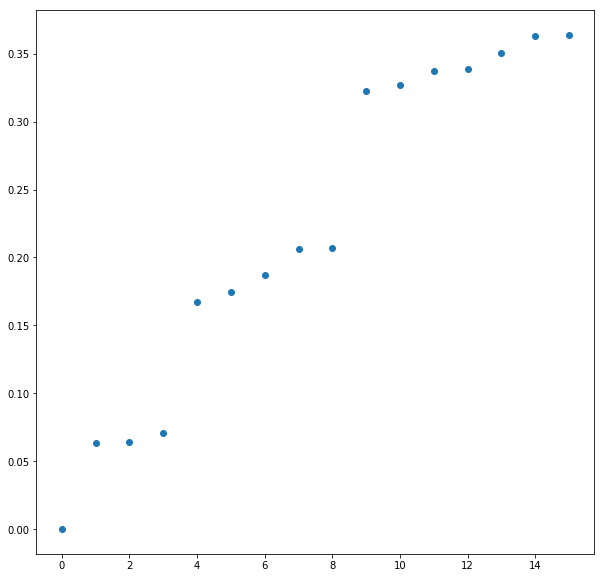

In [779]:
plt.plot(equiNN.e[:16], 'o')

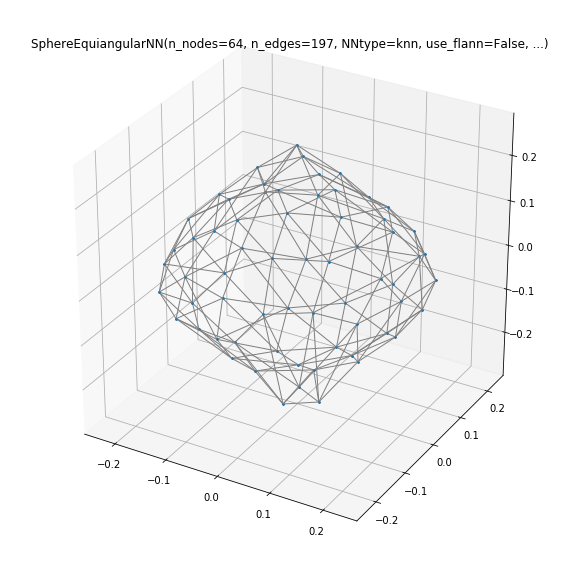

In [781]:
equiNN.compute_laplacian("normalized")
equiNN.compute_fourier_basis(recompute=True)
equiNN.set_coordinates(equiNN.U[:,1:4])
equiNN.plot(vertex_size=10)

In [1042]:
class CylinderEquiangular(Graph):
    def __init__(self, bw=64, sptype='DH', pole='disconnected', neighbors=8, w_mat=None, dist='geodesic', 
                 affine=0., geometry='sphere', delta='one', **kwargs):
        """Sphere with an equiangular sampling
         Parameters
        ----------
        bw : int
            bandwidth, size of grid  (default = 64)
        sptype: str
            sampling type, possible arguments are 'DH', 'SOFT', ... (default = 'DH')
        pole: str
            how to manage the pole of the cylinder, possible arguments are 'disconnected', 'connected' (default = 'disconnected')
        ---------
        TODO: unique on neighbor
        TODO: CC and GL are not equiangular and must be implement in other ways
        """
        self.bw = bw
        self.sptype = sptype
        self.pole = pole
        if pole not in ['disconnected', 'connected']:
            raise ValueError('Unknown pole value:' + pole) 
        if sptype not in ['DH', 'SOFT', 'CC', 'GL']:
            raise ValueError('Unknown sampling type:' + sptype) 
        if neighbors not in [4, 8, 'all']:
            raise ValueError('impossible numbers of neighbors:' + neighbors) 
        
        ## sampling and coordinates calculation
        if sptype is 'DH':
            beta = np.arange(2 * bw) * np.pi / (2. * bw)  # Driscoll-Heally
            alpha = np.arange(2 * bw) * np.pi / bw
        elif sptype is 'SOFT':  # SO(3) Fourier Transform optimal
            beta = np.pi * (2 * np.arange(2 * bw) + 1) / (4. * bw)
            alpha = np.arange(2 * bw) * np.pi / bw
        elif sptype == 'CC':  # Clenshaw-Curtis
            beta = np.linspace(0, np.pi, 2 * bw + 1)
            alpha = np.linspace(0, 2 * np.pi, 2 * bw + 2, endpoint=False)
        elif sptype == 'GL':  # Gauss-legendre
            from numpy.polynomial.legendre import leggauss
            x, _ = leggauss(bw + 1)  # TODO: leggauss docs state that this may not be only stable for orders > 100
            beta = np.arccos(x)
            alpha = np.arange(2 * bw + 2) * np.pi / (bw + 1)
        theta, phi = np.meshgrid(*(beta, alpha),indexing='ij')
        self.lat, self.lon = theta.shape
        # do we want cylinder coordinates?
        if geometry == 'sphere':
            ct = np.cos(theta).flatten()
            st = np.sin(theta).flatten()
        elif geometry == 'cylinder':
            ct = theta.flatten() * 2 * bw / np.pi
            st = 1
        cp = np.cos(phi).flatten()
        sp = np.sin(phi).flatten()
        x = st * cp
        y = st * sp
        z = ct
        coords = np.vstack([x, y, z]).T
        coords = np.asarray(coords, dtype=np.float32)
        self.npix = len(coords)
        
        ## neighbors and weight matrix calculation
        def one(x):
            return 1
        if delta == 'one':
            fun = one
        else:
            def fun(x):
                lat = abs(x//self.lat - self.lat//2)
                delta = 1+lat*(self.lon-1)/self.lat
                return int(delta)
        
        def south(x):
            if x >= self.npix - self.lat:
                if pole == 'connected':
                    return (x + self.lat//2)%self.lat + self.npix - self.lat
                else:
                    return -1
            return x + self.lon

        def north(x):
            if x < self.lat:
                if pole == 'connected':
                    return (x + self.lat//2)%self.lat
                else:
                    return -1
            return x - self.lon

        def west(x, fun=fun):
            delta = fun(x)
            if x%(self.lon)<delta:
                try:
                    assert x//self.lat == (x-delta+self.lon)//self.lat
                except:
                    print(x)
                    print(delta)
                    print(x-delta+self.lon)
                    print(x//self.lat)
                    print((x-delta+self.lon)//self.lat)
                    raise
                x += self.lon
            else:
                try:
                    assert x//self.lat == (x-delta)//self.lat
                except:
                    print(x)
                    print(delta)
                    print(x-delta)
                    print(x//self.lat)
                    print((x-delta)//self.lat)
                    raise
            return x - delta

        def east(x, fun=fun):
            delta = fun(x)
            if x%(self.lon)>=self.lon-delta:
                try:
                    assert x//self.lat == (x+delta-self.lon)//self.lat
                except:
                    print(x)
                    print(delta)
                    print(x+delta-self.lon)
                    print(x//self.lat)
                    print((x+delta-self.lon)//self.lat)
                    raise
                x -= self.lon
            else:
                try:
                    assert x//self.lat == (x+delta)//self.lat
                except:
                    print(x)
                    print(delta)
                    print(x+delta)
                    print(x//self.lat)
                    print((x+delta)//self.lat)
                    raise
            return x + delta

        col_index=[]
        for ind in range(self.npix):
            # first line is the same point, so is connected to all points of second line
            if neighbors==8:
                neighbor = [south(west(ind)), west(ind), north(west(ind)), north(ind), 
                            north(east(ind)), east(ind), south(east(ind)), south(ind)]
            elif neighbors==4:
                neighbor = [west(ind), north(ind), east(ind), south(ind)]
            elif neighbors=='all':
                neighbor = set(range(self.npix))-{ind}
            else:
                neighbor = []
            #neighbor = np.asarray(neighbor)
            col_index += list(neighbor)
        col_index = np.asarray(col_index)
        if neighbors == 'all':
            neighbors = self.npix - 1
        row_index = np.repeat(np.arange(self.npix), neighbors)
        
        keep = (col_index < self.npix)
        keep &= (col_index >= 0)
        col_index = col_index[keep]
        row_index = row_index[keep]
        
        if w_mat is not 'one':
            
            if dist=='geodesic':
                distances = np.zeros(len(row_index))
                for i, (pos1, pos2) in enumerate(zip(coords[row_index], coords[col_index])):
                    d1, d2 = hp.rotator.vec2dir(pos1.T, lonlat=False).T, hp.rotator.vec2dir(pos2.T, lonlat=False).T
                    distances[i] = hp.rotator.angdist(d1, d2, lonlat=False)
            else:
                distances = np.sum((coords[row_index] - coords[col_index])**2, axis=1)

            def fun(x):
                
                val = np.abs(np.arange(x)-x//2)
                val = 0.3+val**1/200
                return val
            if delta != 'one':
                distances[::2] = distances[::2]*4#*fun(len(distances[1::2]))
            # Compute similarities / edge weights.
            kernel_width = np.mean(distances)
            kernel_width2 = np.median(distances)

            slope = (kernel_width2*(0.95-affine))/(kernel_width2*0.95)
            #distances[distances<(kernel_width2*0.95)] = affine*kernel_width2 + distances[distances<(kernel_width2*0.95)] * slope
            distances[distances>(kernel_width2*0.95)] = affine*kernel_width2 + distances[distances>(kernel_width2*0.95)] * slope
            if isinstance(w_mat, int):
                kernel_width = weights
            weights = np.exp(-distances / (2 * kernel_width2))
#             weights = 1/distances

            plt.hist(distances, 100)
        if w_mat == 'one':
            weights = np.ones((len(row_index),))
            near_pole = col_index<2
            near_pole &= col_index>self.lat-2
            weights[near_pole] *= 0.1

        # Similarity proposed by Renata & Pascal, ICCV 2017.
        # weights = 1 / distances

        # Build the sparse matrix.
        W = sparse.csr_matrix(
            (weights, (row_index, col_index)), shape=(self.npix, self.npix), dtype=np.float32)
        
        plotting = {"limits": np.array([-1, 1, -1, 1, -1, 1])}
        super(CylinderEquiangular, self).__init__(W=W, coords=coords,
                                     plotting=plotting, **kwargs)

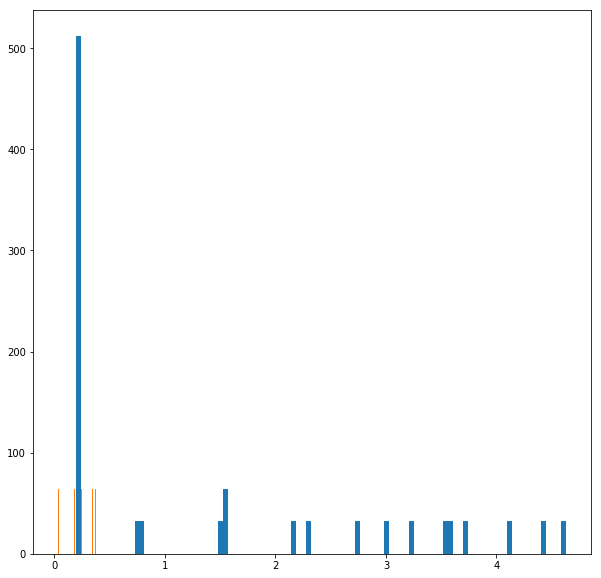

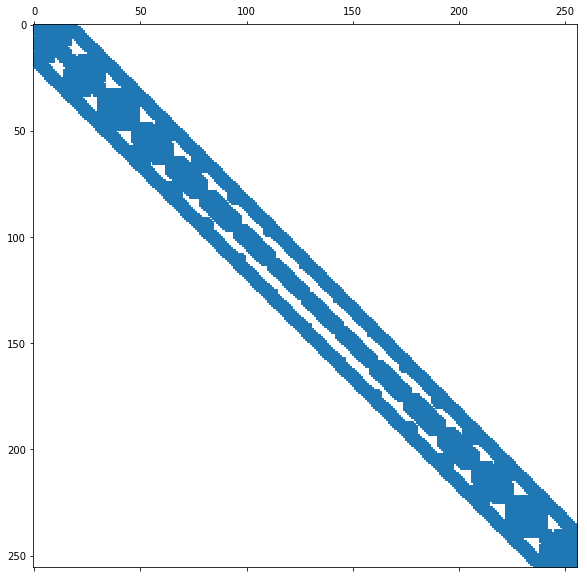

In [1043]:
g1 = CylinderEquiangular(8, 'SOFT', 'connected', neighbors=4, w_mat=None, dist='geodesic', affine=0.0, delta = 'acc')
g2 = CylinderEquiangular(8, 'SOFT', 'connected', neighbors=4, w_mat=None, dist='geodesic', affine=0.0)
diff = g2.W - g1.W
diff[diff>0] = 0
W = g2.W - diff
g = Graph(W=W)
plt.figure()
plt.spy(W)

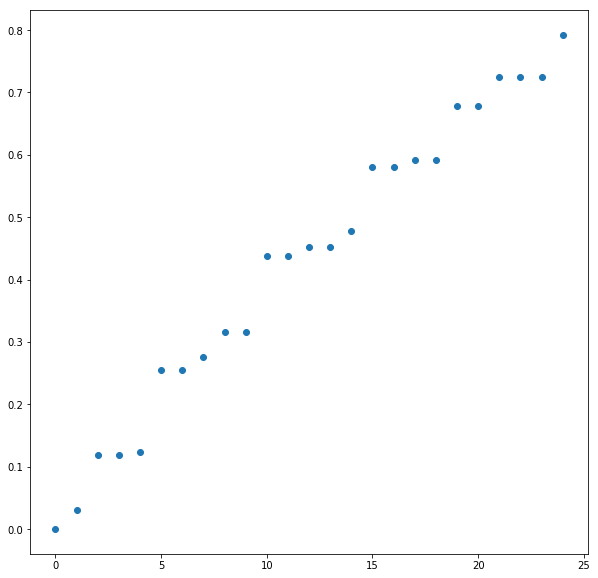

In [1045]:
plt.plot(g.e[:25], 'o')

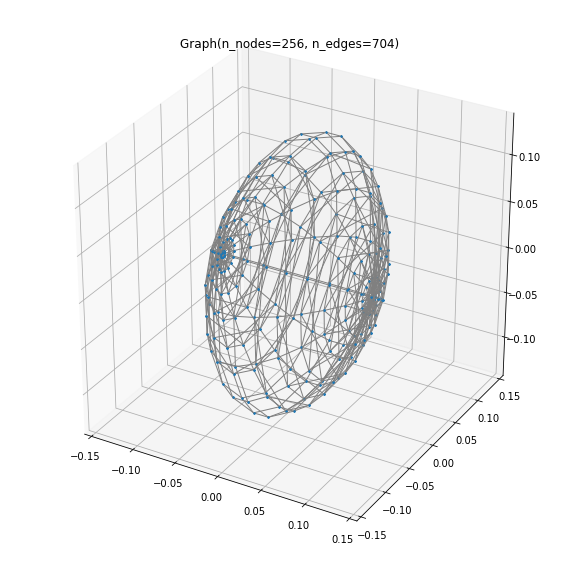

In [1046]:
g.compute_laplacian("combinatorial")
plt.rcParams['figure.figsize'] = [10, 10]
fig=plt.figure()
ax=plt.subplot(111, projection='3d')
#graphCyl.compute_fourier_basis(recompute=True)
g.set_coordinates(g.U[:,1:4])
g.plot(vertex_size=10, ax=ax)

X, Y, Z = g.U[:,1], g.U[:,2], g.U[:,3]
# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')

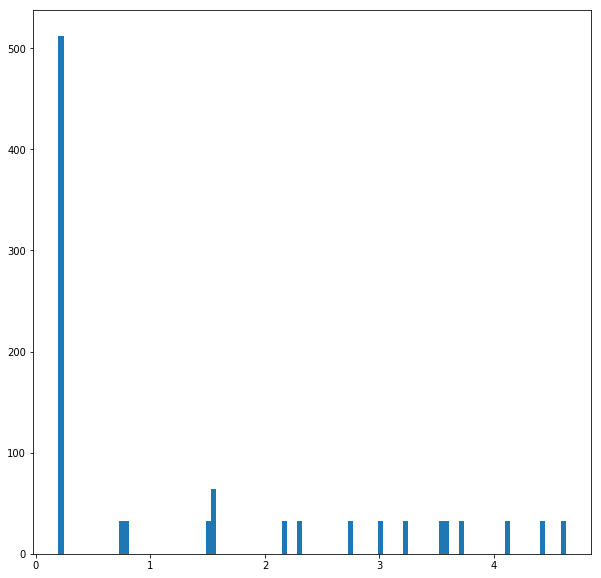

In [1047]:
graphCyl = CylinderEquiangular(8, 'SOFT', 'connected', neighbors=4, w_mat=None, dist='geodesic', affine=0.0, delta = 'acc')

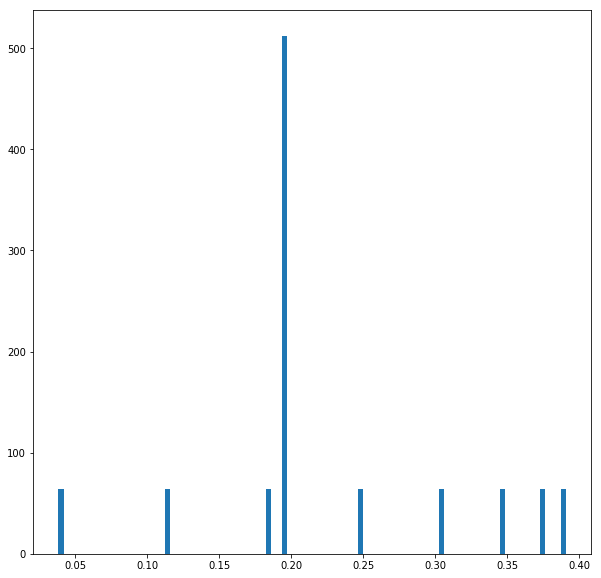

In [866]:
graphCyl = CylinderEquiangular(8, 'SOFT', 'connected', neighbors=4, w_mat=None, dist='geodesic', affine=0.0)

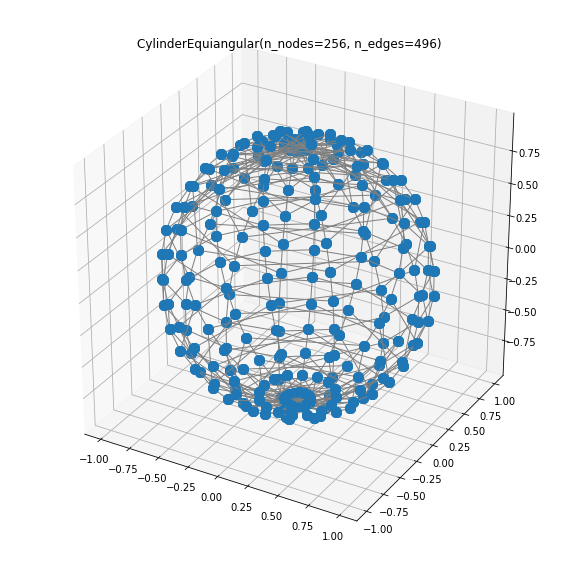

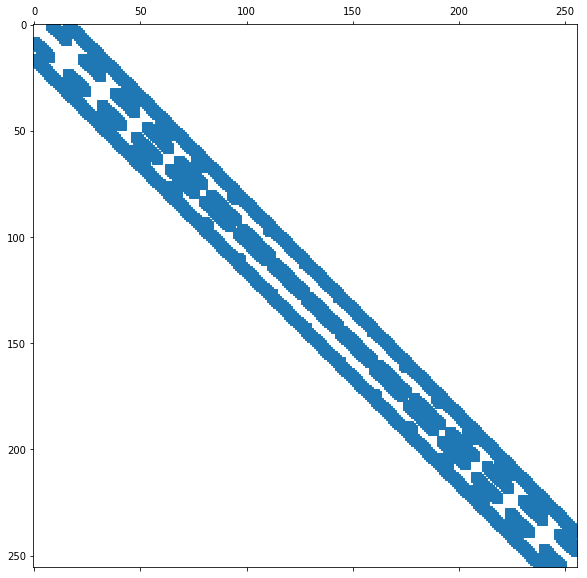

In [913]:
graphCyl.plot()
plt.figure()
plt.spy(graphCyl.W)

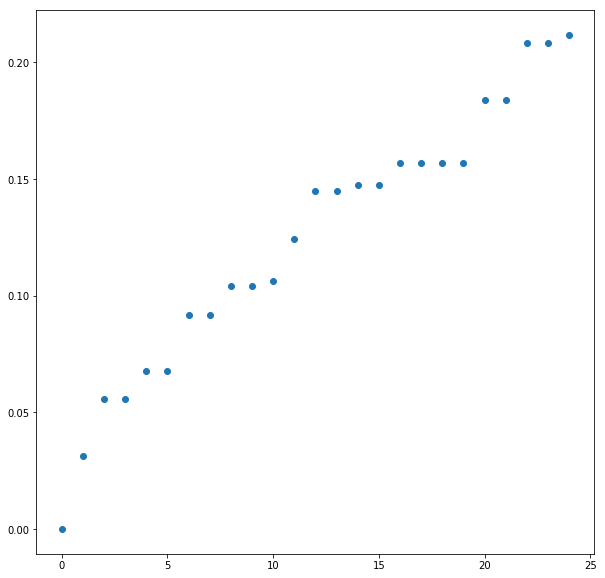

In [1049]:
plt.plot(graphCyl.e[:25], 'o')

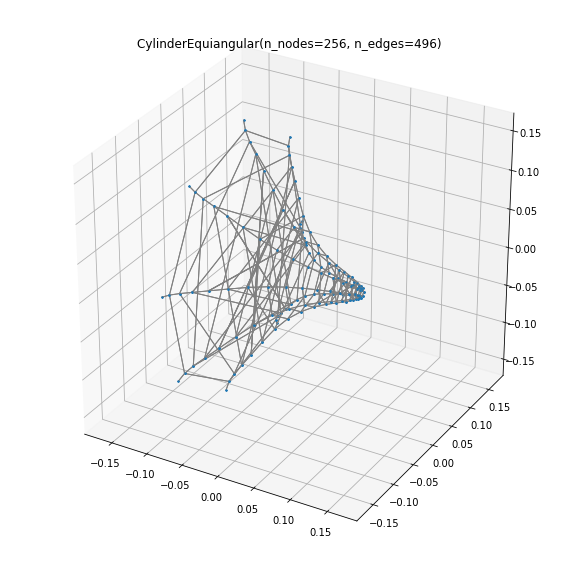

In [1050]:
graphCyl.compute_laplacian("combinatorial")
plt.rcParams['figure.figsize'] = [10, 10]
fig=plt.figure()
ax=plt.subplot(111, projection='3d')
#graphCyl.compute_fourier_basis(recompute=True)
graphCyl.set_coordinates(graphCyl.U[:,1:4])
graphCyl.plot(vertex_size=10, ax=ax)

X, Y, Z = graphCyl.U[:,1], graphCyl.U[:,2], graphCyl.U[:,3]
# Create cubic bounding box to simulate equal aspect ratio
max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# Comment or uncomment following both lines to test the fake bounding box:
for xb, yb, zb in zip(Xb, Yb, Zb):
    ax.plot([xb], [yb], [zb], 'w')

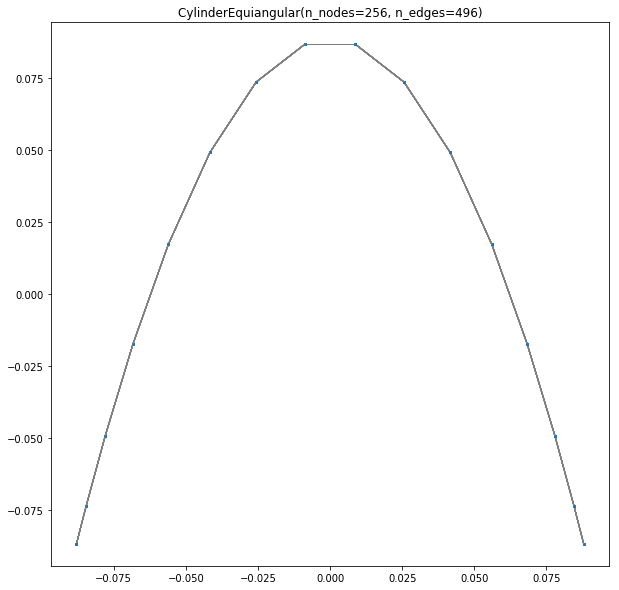

In [926]:
graphCyl.compute_laplacian("combinatorial")
plt.rcParams['figure.figsize'] = [10, 10]
fig=plt.figure()
ax=plt.subplot(111)
ax.axis('equal')
#graphCyl.compute_fourier_basis(recompute=True)
graphCyl.set_coordinates(graphCyl.U[:,1:3])
graphCyl.plot(vertex_size=10, ax=ax)

# X, Y, Z = graphCyl.U[:,1], graphCyl.U[:,2], graphCyl.U[:,3]
# # Create cubic bounding box to simulate equal aspect ratio
# max_range = np.array([X.max()-X.min(), Y.max()-Y.min(), Z.max()-Z.min()]).max()
# Xb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][0].flatten() + 0.5*(X.max()+X.min())
# Yb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][1].flatten() + 0.5*(Y.max()+Y.min())
# Zb = 0.5*max_range*np.mgrid[-1:2:2,-1:2:2,-1:2:2][2].flatten() + 0.5*(Z.max()+Z.min())
# # Comment or uncomment following both lines to test the fake bounding box:
# for xb, yb, zb in zip(Xb, Yb, Zb):
#     ax.plot([xb], [yb], [zb], 'w')

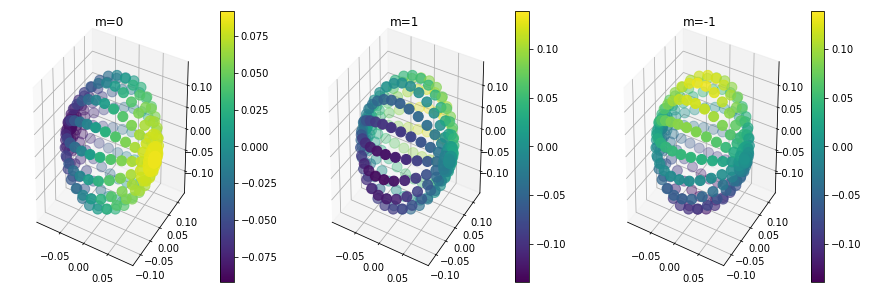

In [705]:
graphCyl.set_coordinates(graphCyl.U[:,1:4])
plt.rcParams['figure.figsize'] = [15, 5]
#fig = plt.figure()
ax1 = plt.subplot(131, projection='3d')
ax2 = plt.subplot(132, projection='3d')
ax3 = plt.subplot(133, projection='3d')
ax1.axis('equal')
ax2.axis('equal')
ax3.axis('equal')
graphCyl.plot_signal(graphCyl.U[:,1], ax=ax1, title='m=0', edges=False)
graphCyl.plot_signal(graphCyl.U[:,2], ax=ax2, title='m=1', edges=False)
graphCyl.plot_signal(graphCyl.U[:,3], ax=ax3, title='m=-1', edges=False)

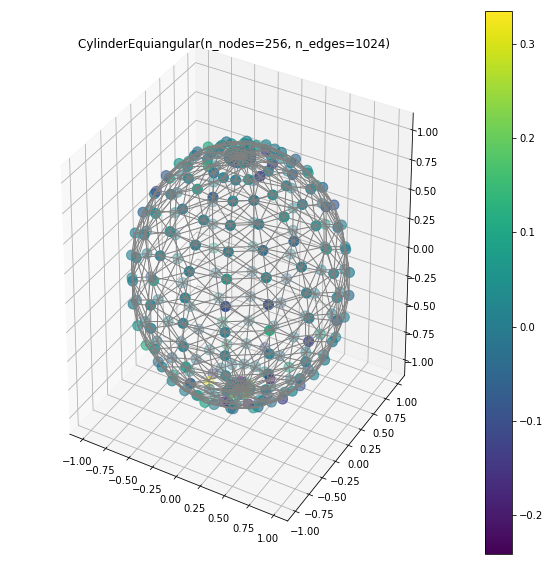

In [409]:
graphCyl.plot_signal(graphCyl.U[0])

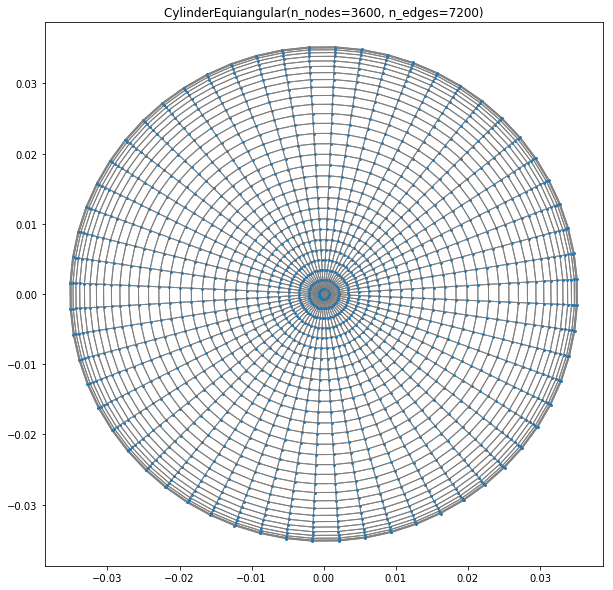

In [350]:
graphCyl.set_coordinates(graphCyl.U[:,2:4])
graphCyl.plot(vertex_size=10)

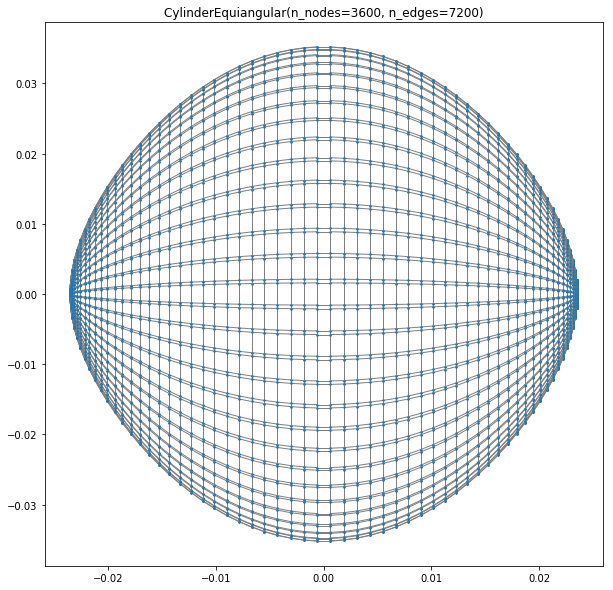

In [351]:
graphCyl.set_coordinates(graphCyl.U[:,1:3])
graphCyl.plot(vertex_size=10)

In [430]:
from scipy.special import sph_harm

In [454]:
def geodesic_distance(pos1, pos2):
    """
        posx is pixel position (lat, lon) (ndarray)
        return geodesic distance between two pixels on the sphere
    """
    sin_lat1, sin_lon1 = np.sin(pos1)
    cos_lat1, cos_lon1 = np.cos(pos1)
    sin_lat2, sin_lon2 = np.sin(pos2)
    cos_lat2, cos_lon2 = np.cos(pos2)
    delta_lat, delta_lon = np.abs(pos1-pos2)
    sqrt = np.sqrt((cos_lat2*np.sin(delta_lon))**2+(cos_lat1*sin_lat2-sin_lat1*cos_lat2*np.cos(delta_lon))**2)
    div = sqrt/(sin_lat1*sin_lat2+cos_lat1*cos_lat2*np.cos(delta_lon))
    return np.arctan(div)

In [478]:
geodesic_distance(np.array([0.,0.]), np.array([np.pi*0.9, 0.]))/np.pi

-0.10000000000000003

In [483]:
graphCyl = CylinderEquiangular(10, 'SOFT', 'disconnected', neighbors=4, w_mat='one', 
                               dist='euclidean', geometry='cylinder', affine=0.0)

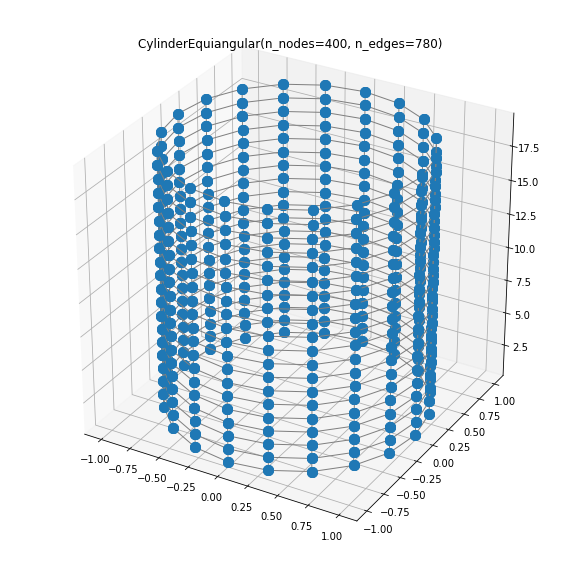

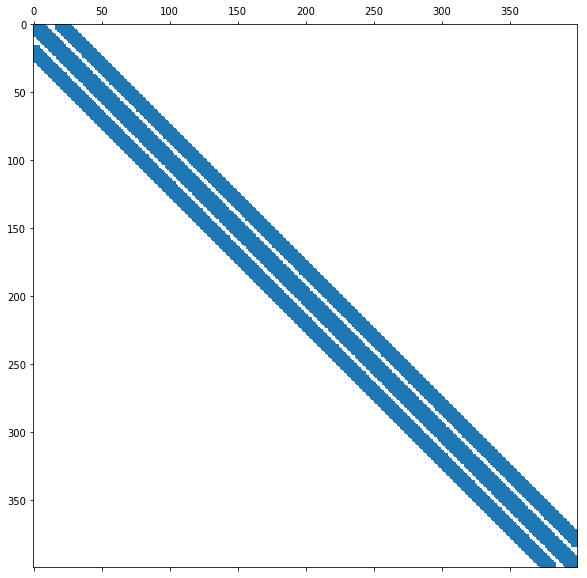

In [484]:
graphCyl.plot()
plt.figure()
plt.spy(graphCyl.W)

2019-04-30 14:20:08,558:[WARNING](pygsp.graphs.graph._check_fourier_properties): The eigenvalues vector G.e is not available, we need to compute the Fourier basis. Explicitly call G.compute_fourier_basis() once beforehand to suppress the warning.


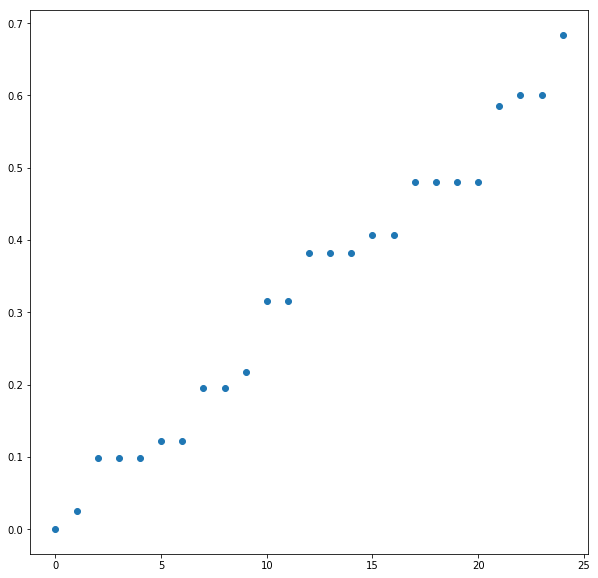

In [485]:
plt.plot(graphCyl.e[:25], 'o')

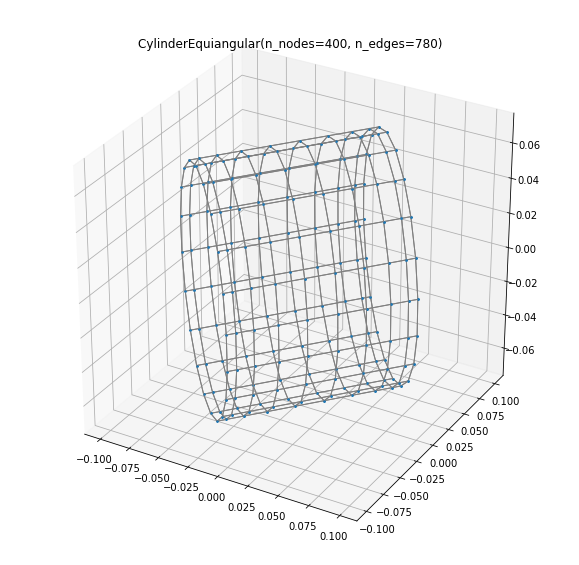

<Figure size 720x720 with 0 Axes>

In [487]:
graphCyl.compute_laplacian("normalized")
#graphCyl.compute_fourier_basis(recompute=True)
graphCyl.set_coordinates(graphCyl.U[:,2:5])
graphCyl.plot(vertex_size=10)
fig=plt.figure()